<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Introduction
    <a href='https://data.mendeley.com/datasets/wj9rwkp9c2/1'> [ref] </a>
</h2>

> Diabetes is a global health concern demanding accurate diagnosis and management. The "Diabetes Dataset," curated by Rashid, Ahlam in 2020, offers a wealth of patient data from Iraqi medical institutions, categorized into Diabetic, Non-Diabetic, and Predicted-Diabetic classes. In this project, we utilize machine learning to predict diabetes across these categories, aiming to enhance diagnostic accuracy and contribute to effective treatment strategies.
>> <strong> Rashid, Ahlam (2020), “Diabetes Dataset”, Mendeley Data, V1, doi: 10.17632/wj9rwkp9c2.1

<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Import Libraries
</h2>

In [1]:
import shap
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import bokeh.plotting as bp
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN
from catboost import CatBoostClassifier
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Load and Explore Data
</h2>

In [2]:
# download data from source url

url = "https://data.mendeley.com/public-files/datasets/wj9rwkp9c2/files/2eb60cac-96b8-46ea-b971-6415e972afc9/file_downloaded"
filename = "diabetes_data.csv"

response = requests.get(url)
with open(filename, "wb") as file:
    file.write(response.content)

In [3]:
# load the downloaded data to pandas data frame

Xy = pd.read_csv('diabetes_data.csv')
Xy.head(1)

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N


In [4]:
# data general info

Xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB


In [5]:
# summarize each column

def generate_column_summary(df, num_examples=3):
    # initialize an empty DataFrame
    summary_df = pd.DataFrame(columns=['Column_Name', 'Unique_Count', 'Data_Type', 'Examples'])

    # iterate through each column in the input DataFrame
    for column in df.columns:
        # get data type of the column
        data_type = df[column].dtype

        # get the total number of unique values in the column
        num_unique_values = df[column].nunique()

        # get unique examples from the column as a list
        unique_examples = df[column].unique()[:num_examples]

        # append the new information for each column
        summary_df = pd.concat([summary_df, pd.DataFrame({
            'Column_Name': [column],
            'Unique_Count': [num_unique_values],
            'Data_Type': [data_type],
            'Examples': [list(unique_examples)]
        })], ignore_index=True)
    return summary_df
summary_df = generate_column_summary(Xy, num_examples=5)
print(summary_df)

   Column_Name Unique_Count Data_Type                             Examples
0           ID          800     int64            [502, 735, 420, 680, 504]
1    No_Pation          961     int64  [17975, 34221, 47975, 87656, 34223]
2       Gender            3    object                            [F, M, f]
3          AGE           50     int64                 [50, 26, 33, 45, 48]
4         Urea          110   float64            [4.7, 4.5, 7.1, 2.3, 2.0]
5           Cr          113     int64                 [46, 62, 24, 50, 47]
6        HbA1c          111   float64            [4.9, 4.0, 4.2, 4.1, 5.1]
7         Chol           77   float64            [4.2, 3.7, 4.9, 2.9, 3.6]
8           TG           69   float64            [0.9, 1.4, 1.0, 1.3, 0.8]
9          HDL           48   float64            [2.4, 1.1, 0.8, 1.0, 0.9]
10         LDL           65   float64            [1.4, 2.1, 2.0, 1.5, 1.6]
11        VLDL           60   float64            [0.5, 0.6, 0.4, 1.0, 0.3]
12         BMI           

<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Data Cleaning
</h2>

In [6]:
# convert text to lower case and remove extra spaces

def process_text(value):
    if isinstance(value, str):
        return value.lower().strip()
    else:
        return value
Xy = Xy.map(process_text)

In [7]:
# remove duplicate rows if exist

Xy = Xy.drop_duplicates().reset_index(drop=True)

In [8]:
# remove columnss with all NaN values if exist

nan_columns = Xy.columns[Xy.isnull().all()]
Xy = Xy.drop(columns=nan_columns)

In [9]:
# check for missing values

def check_missing(df):
    
    # calculate total missing values and percentage missing for each column
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().mean() * 100).round(2).sort_values(ascending=False)
    
    # combine total missing values and percentage missing into a single DataFrame
    missing_data = pd.concat([total_missing, percentage], axis=1, keys=['TotalMissing', 'PercentMissing'])
    
    # filter out columns that have no missing data
    missing_data = missing_data[missing_data['TotalMissing'] > 0]
    
    return missing_data
missing = check_missing(Xy)
print(missing)

Empty DataFrame
Columns: [TotalMissing, PercentMissing]
Index: []


In [10]:
# drop irrelevant columns

Xy = Xy.drop(columns=['ID', 'No_Pation'])

In [11]:
# encode to convert category data to numeric

# encode with label encoder
encode_1 = LabelEncoder()
Xy['Gender'] = encode_1.fit_transform(Xy['Gender'])
encode_2 = LabelEncoder()
Xy['CLASS'] = encode_2.fit_transform(Xy['CLASS'])

# get the mapping of encoded labels to original classes
gender_mapping = dict(zip(encode_1.classes_, encode_1.transform(encode_1.classes_)))
class_mapping = dict(zip(encode_2.classes_, encode_2.transform(encode_2.classes_)))

# print the mapping
print("Mapping of encoded labels to original classes for Gender:")
print(gender_mapping)
print("\nMapping of encoded labels to original classes for CLASS:")
print(class_mapping)

Mapping of encoded labels to original classes for Gender:
{'f': 0, 'm': 1}

Mapping of encoded labels to original classes for CLASS:
{'n': 0, 'p': 1, 'y': 2}


In [12]:
# check summary

summary_df = generate_column_summary(Xy, num_examples=3)
print(summary_df)

   Column_Name Unique_Count Data_Type            Examples
0       Gender            2     int32              [0, 1]
1          AGE           50     int64        [50, 26, 33]
2         Urea          110   float64     [4.7, 4.5, 7.1]
3           Cr          113     int64        [46, 62, 24]
4        HbA1c          111   float64     [4.9, 4.0, 4.2]
5         Chol           77   float64     [4.2, 3.7, 4.9]
6           TG           69   float64     [0.9, 1.4, 1.0]
7          HDL           48   float64     [2.4, 1.1, 0.8]
8          LDL           65   float64     [1.4, 2.1, 2.0]
9         VLDL           60   float64     [0.5, 0.6, 0.4]
10         BMI           64   float64  [24.0, 23.0, 21.0]
11       CLASS            3     int32           [0, 1, 2]


In [13]:
# seperate features and target variable

X = Xy.drop(columns='CLASS')
y = Xy['CLASS']

<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Data Analysis
</h2>

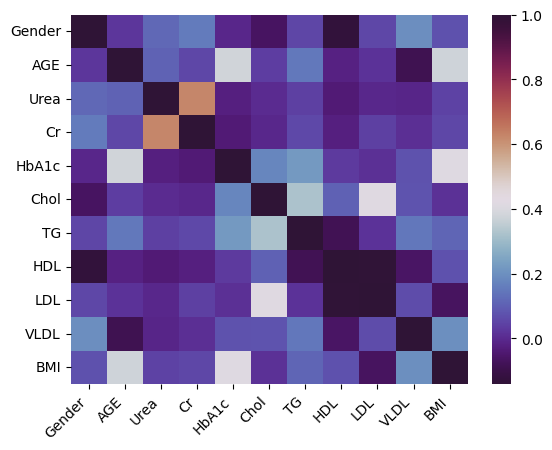

In [14]:
# correlation matrix and heatmap of features

# calculate correlation matrix
corr = X.corr()

# choose color palette
custom_palette = sns.color_palette('twilight_shifted', as_cmap=True)

# create heatmap using above color palette
ax = sns.heatmap(corr, cmap=custom_palette)

# adjust x-axis labels for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

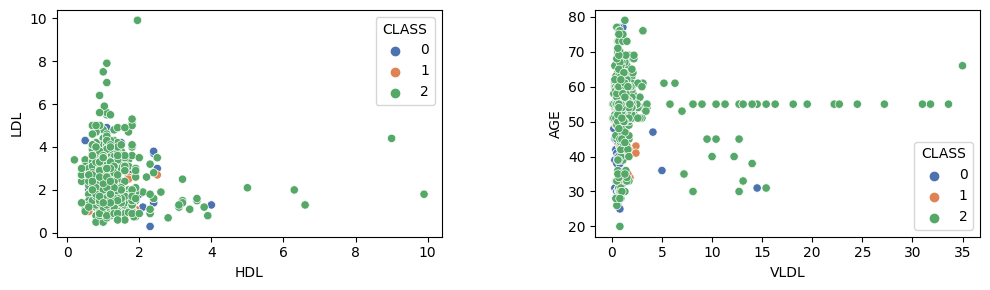

In [15]:
# correlation between HDL, LDL, VLDL and AGE

# create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

sns.scatterplot(data=X, x='HDL', y='LDL', hue=y, ax=axes[0], palette='deep')
sns.scatterplot(data=X, x='VLDL', y='AGE', hue=y, ax=axes[1], palette='deep')

# adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)

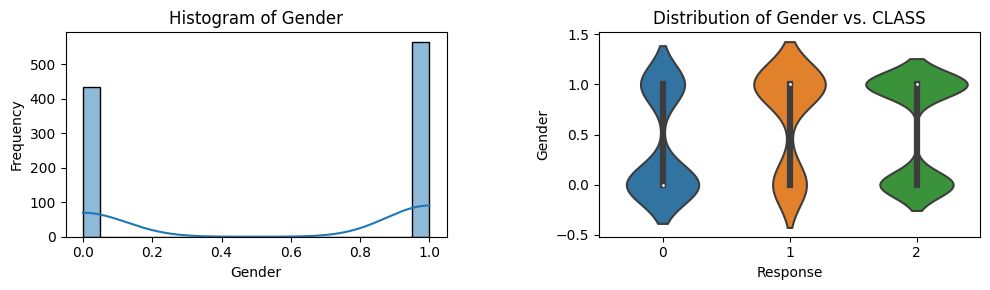

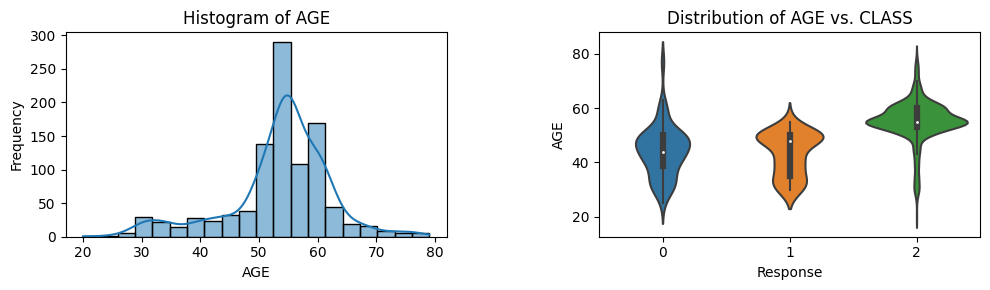

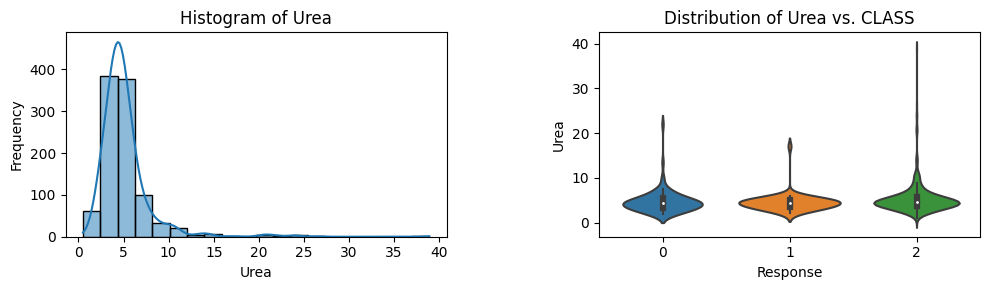

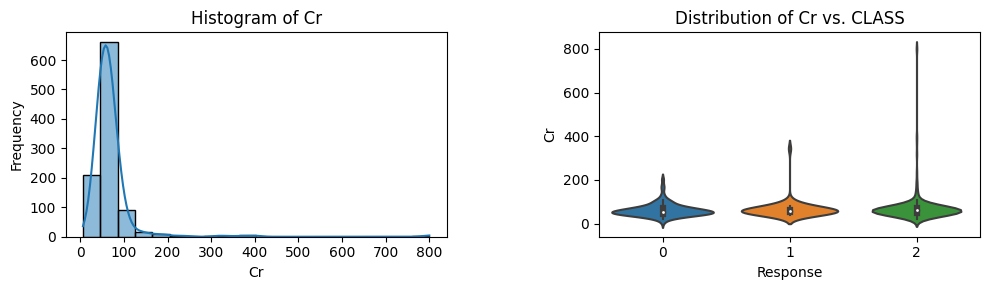

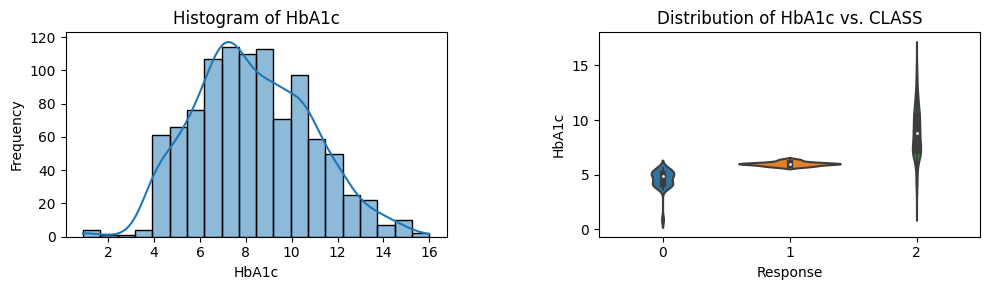

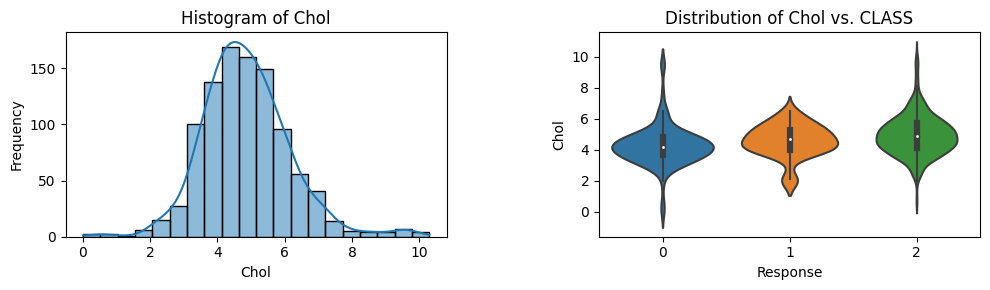

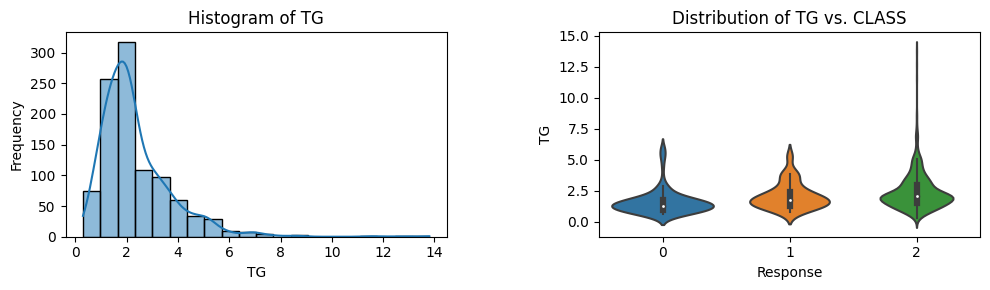

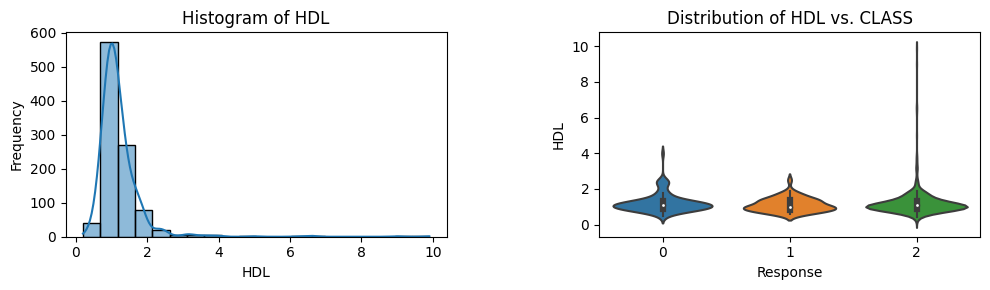

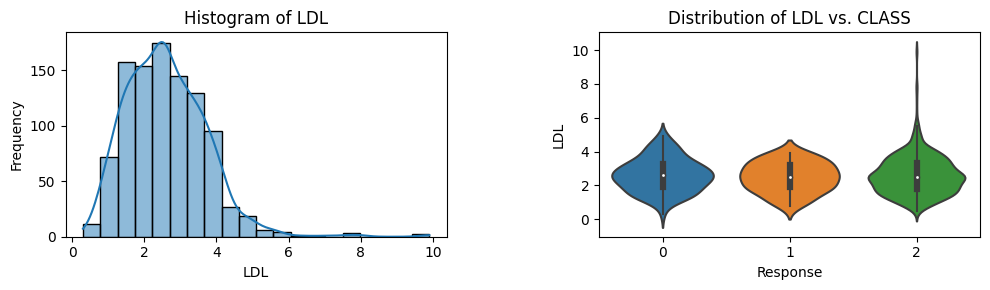

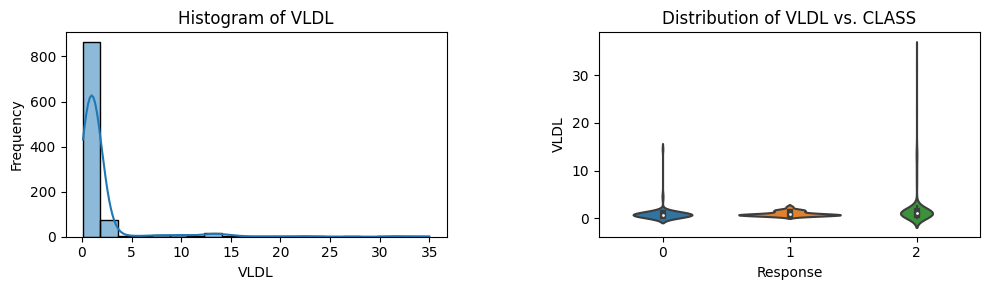

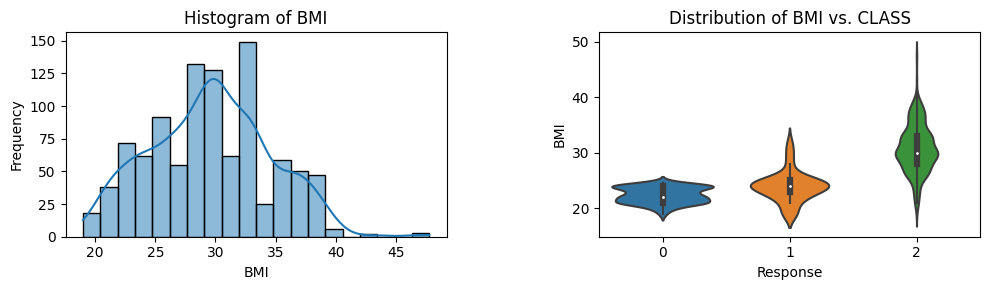

In [16]:
# interaction between features and the target Response

# using histogram and violine plots
for i, col in enumerate(X.columns):
    
    # initialize figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    
    # plot histogram
    sns.histplot(x=X[col], bins=20, kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')
    
    # plot violin plot
    sns.violinplot(x=y, y=X[col], ax=axes[1])
    axes[1].set_title(f'Distribution of {col} vs. CLASS')
    axes[1].set_xlabel('Response')
    axes[1].set_ylabel(col)
    
    # adjust layout
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)

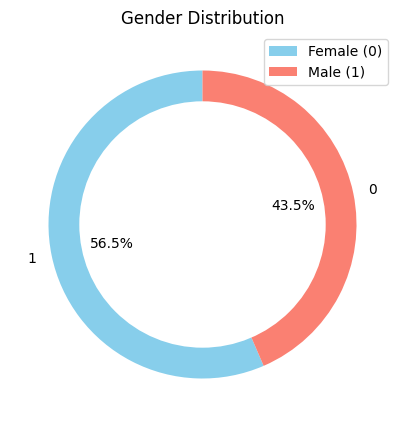

In [17]:
# imbalance in Gender distribution

# count the occurrences of each 'Gender' category 
gender_counts = X['Gender'].value_counts()

# create a donut chart
plt.figure(figsize=(5, 5))
patches, texts, _ = plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.gca().add_artist(plt.Circle((0,0),0.80,fc='white'))  # Add a circle to create a donut chart
plt.title('Gender Distribution')

# add legend for gender labels
plt.legend(patches, ['Female (0)', 'Male (1)'], loc='upper right');

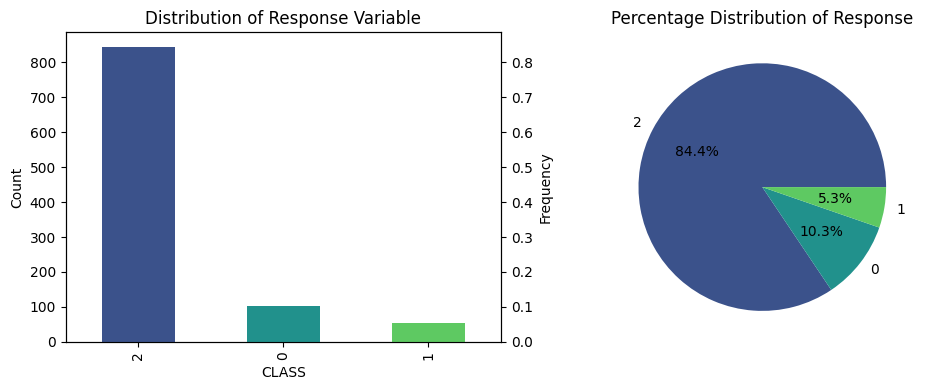

In [18]:
# imbalance in CLASS distribution

# create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
colors = sns.color_palette("viridis", 3)

# plot of count distribution
ax_left = y.value_counts().plot(kind='bar', title='Distribution of Response Variable', color=colors, ylabel='Count', ax=axes[0])

# create a bar plot to merge count and frequency plots
ax_right = ax_left.twinx()

# plot of frequency distribution
(y.value_counts() / y.size).plot(kind='bar', ylabel='Frequency', ax=ax_right, color=colors)
ax_right.get_xaxis().set_visible(False)  # hide the secondary x-axis

# create a pie plot
y.value_counts().plot.pie(autopct='%1.1f%%',ax=axes[1], ylabel='', title='Percentage Distribution of Response', colors=colors)

# adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

<h2 
    align='center' 
    style='font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;'>
    Cross Validation
</h2>

In [19]:
# split the dataset with stratify*

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

X_train shape: (800, 11), X_test shape: (200, 11), y_train shape: (800,), y_test shape: (200,)


In [20]:
# pipeline for cross validating the train set

# classifiers to validate
classifiers = {
    'DT': DecisionTreeClassifier(random_state=100),
    'RF': RandomForestClassifier(random_state=100),
    'GB': GradientBoostingClassifier(random_state=100),
    'xgb': XGBClassifier(random_state=100),
    'catb': CatBoostClassifier(loss_function='MultiClass', verbose=False, random_seed=100),
    'lgbm': LGBMClassifier(verbose=-1, random_state=100),
    'ab': AdaBoostClassifier(random_state=100)}

# cross-validation strategy
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
f1_scorer = make_scorer(f1_score, average='weighted')

# perform cross-validation for each classifier using pipeline
results = {}
for clf_name, clf in classifiers.items():
    pipeline = make_pipeline(
        SMOTEENN(random_state=100),
        StandardScaler(),
        clf)
    
    scores = cross_val_score(pipeline, X_train, y_train, scoring=f1_scorer, cv=skf)
    results[clf_name] = scores.mean()

results_df = pd.DataFrame(list(results.items()), columns=['models', 'f1_score']).sort_values(by='f1_score')
results_df.T

,1,4,0,6,2,3,5
models,RF,catb,DT,ab,GB,xgb,lgbm
f1_score,0.949988,0.951152,0.951511,0.961808,0.962099,0.967083,0.967296


<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Evaluate Models
</h2>

In [21]:
# plot the f1_scores of validated models

# set the input
classifiers = list(results.keys())
scores = list(results.values())
bp.output_notebook()

# make the plot
p = bp.figure(title='Mean F1 Scores of Models', width=600, height=350, x_range=classifiers)
p.line(classifiers, scores, line_width=2)
p.circle(classifiers, scores, fill_color="red", size=8)
p.title.text_font_size = '16pt'
p.yaxis.axis_label_text_font_size = "14pt"
p.xaxis.axis_label_text_font_size = "14pt"
#p.xaxis.major_label_orientation = 1.57
bp.show(p)

Loading BokehJS ...

In [22]:
# retrain the best model with full training set and predict

# pipeline for preprocessing
pipeline = make_pipeline(
        SMOTEENN(random_state=100),
        StandardScaler(),
        LGBMClassifier(verbose=-1, random_state=100))

# train and predict
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)

# compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy}, F1 Score: {f1}')

Accuracy: 0.97, F1 Score: 0.9716039156626506


In [23]:
# classification report
## {'n': 0, 'p': 1, 'y': 2}

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        21
           1       1.00      1.00      1.00        10
           2       1.00      0.96      0.98       169

    accuracy                           0.97       200
   macro avg       0.93      0.99      0.95       200
weighted avg       0.98      0.97      0.97       200



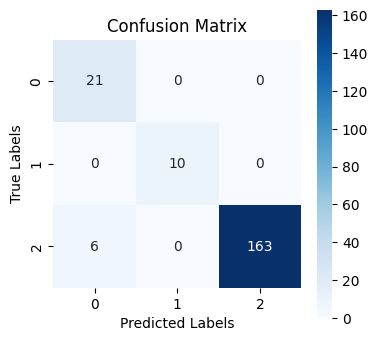

In [24]:
# confusion matrix

# compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# confusion matrix heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix');

<h2 
    align="center" 
    style="font-size: 40px; border-bottom: 2px solid black; border-top: 2px solid black; padding: 30px 0;">
    Model Interpretation
    <a href='https://towardsdatascience.com/shap-for-binary-and-multiclass-target-variables-ff2f43de0cf4'> [shap_ref] </a>,
    <a href='https://marcotcr.github.io/lime/tutorials/Lime%20-%20multiclass.html'> [lime_ref] </a>
</h2>

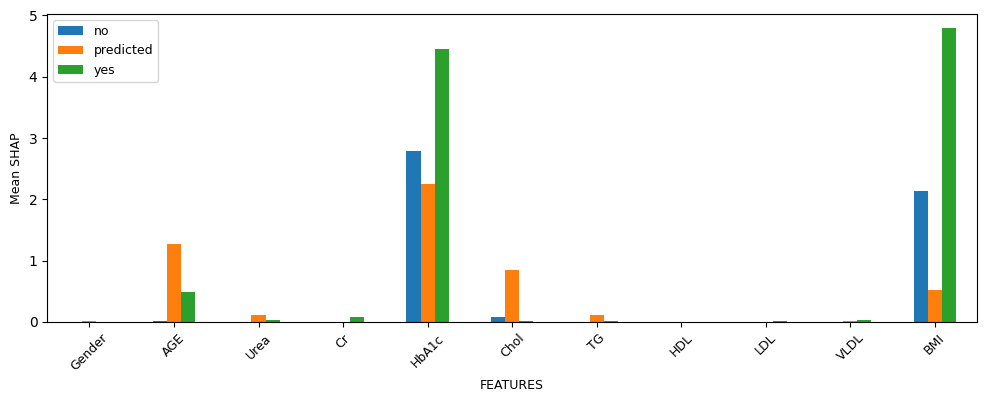

In [25]:
# using SHAP explainer

# extract model importance from the pipeline
best_model = pipeline.named_steps['lgbmclassifier']

# get shap values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

# calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values.values[:,:,0]),axis=0)
mean_1 = np.mean(np.abs(shap_values.values[:,:,1]),axis=0)
mean_2 = np.mean(np.abs(shap_values.values[:,:,2]),axis=0)

# plot mean SHAP values
shap_df = pd.DataFrame({'no':mean_0,'predicted':mean_1,'yes':mean_2})
fig,ax = plt.subplots(1,1,figsize=(12,4))
shap_df.plot.bar(ax=ax) #shap_df.plot.bar(ax=ax, stacked=True)
ax.set_ylabel('Mean SHAP',size=9)
ax.set_xlabel('FEATURES',size=9)
ax.set_xticklabels(X.columns,rotation=45,size=9)
ax.legend(fontsize=9);

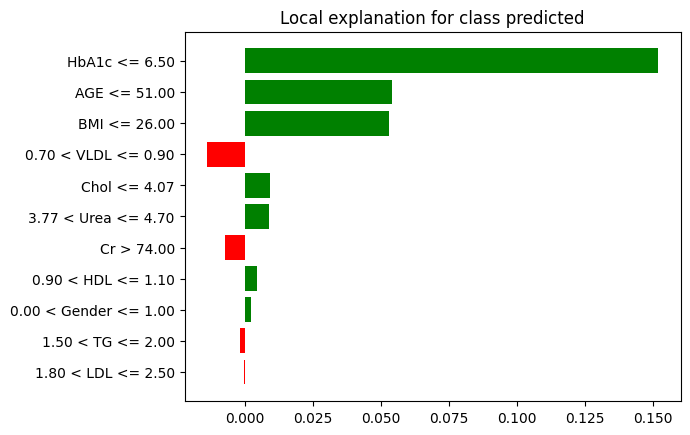

In [26]:
# using lime explainer - local explanation for single instance

# initialize a LIME lime_explainer
lime_explainer = LimeTabularExplainer(training_data=np.array(X_train), feature_names=X_train.columns,
                                 class_names=['no','predicted','yes'], mode='classification')

# generate LIME explanation for instance iloc[0]
exp = lime_explainer.explain_instance(data_row=X_test.iloc[0], predict_fn=pipeline.predict_proba, num_features=11, top_labels=3)

# visualize the explanation
fig1 = exp.as_pyplot_figure()
#fig1.savefig('lime_report1.jpg')

In [27]:
# using lime explainer for single instance

# initialize a LIME lime_explainer
lime_explainer = LimeTabularExplainer(training_data=np.array(X_train), feature_names=X_train.columns,
                                 class_names=['no','predicted','yes'], mode='classification')

# generate LIME explanation for instance iloc[0]
exp = lime_explainer.explain_instance(data_row=X_test.iloc[0], predict_fn=pipeline.predict_proba, num_features=11, top_labels=3)

# visualize the explanation
fig2 = exp.show_in_notebook(show_table=True, show_all=True)